### Preliminaries

In [1]:
import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal

from tqdm import tqdm
from scipy.stats import gumbel_r, multinomial, norm
import statsmodels.formula.api as sm
import statsmodels 
from statsmodels.sandbox.regression.gmm import GMM, IV2SLS, IVGMM, GMMResults

import seaborn as sns
import matplotlib.pyplot as plt

Some computation in the GMMResult class used by statsmodel.sandbox.regression.gmm had a strang behavior, so I changed it. Here I just redefine the modified class. Essentially, ignore the following code block

In [2]:
from statsmodels.compat.python import lrange

import numpy as np
from scipy import optimize, stats

from statsmodels.tools.numdiff import approx_fprime
from statsmodels.base.model import (Model,
                                    LikelihoodModel, LikelihoodModelResults)
from statsmodels.regression.linear_model import (OLS, RegressionResults,
                                                 RegressionResultsWrapper)
import statsmodels.stats.sandwich_covariance as smcov
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.tools import _ensure_2d

class GMMResults(LikelihoodModelResults):
    '''just a storage class right now'''

    use_t = False

    def __init__(self, *args, **kwds):
        self.__dict__.update(kwds)
        self.weights = kwds["weights"]
        self.nobs = self.model.nobs
        self.df_resid = np.inf

        #self.cov_params_default = self._cov_params()

    @cache_readonly
    def q(self):
        """Objective function at params"""
        return self.model.gmmobjective(self.params, self.weights)

    @cache_readonly
    def jval(self):
        """nobs_moms attached by momcond_mean"""
        return self.q * self.model.nobs_moms

    def _cov_params(self, **kwds):
        #TODO add options ???)
        # this should use by default whatever options have been specified in
        # fit

        # TODO: do not do this when we want to change options
#         if hasattr(self, '_cov_params'):
#             #replace with decorator later
#             return self._cov_params

        # set defaults based on fit arguments
        if 'wargs' not in kwds:
            # Note: we do not check the keys in wargs, use either all or nothing
            kwds['wargs'] = self.wargs
        if 'weights_method' not in kwds:
            kwds['weights_method'] = self.options_other['weights_method']
        if 'has_optimal_weights' not in kwds:
            kwds['has_optimal_weights'] = self.options_other['has_optimal_weights']

        gradmoms = self.model.gradient_momcond(self.params)
        moms = self.model.momcond(self.params)
        covparams = self.calc_cov_params(moms, gradmoms, use_weights=True, **kwds)

        return covparams


    def calc_cov_params(self, moms, gradmoms, weights=None, use_weights=True,
                                              has_optimal_weights=True,
                                              weights_method='cov', wargs=()):
        '''calculate covariance of parameter estimates

        not all options tried out yet

        If weights matrix is given, then the formula use to calculate cov_params
        depends on whether has_optimal_weights is true.
        If no weights are given, then the weight matrix is calculated with
        the given method, and has_optimal_weights is assumed to be true.

        (API Note: The latter assumption could be changed if we allow for
        has_optimal_weights=None.)

        '''

        nobs = moms.shape[0]

        if weights is None:
            #omegahat = self.model.calc_weightmatrix(moms, method=method, wargs=wargs)
            #has_optimal_weights = True
            #add other options, Barzen, ...  longrun var estimators
            # TODO: this might still be inv_weights after fititer
            weights = self.weights
        else:
            pass
            #omegahat = weights   #2 different names used,
            #TODO: this is wrong, I need an estimate for omega

        if use_weights:
            omegahat = weights
        else:
            omegahat = self.model.calc_weightmatrix(
                                                moms,
                                                weights_method=weights_method,
                                                wargs=wargs,
                                                params=self.params)


        if has_optimal_weights: #has_optimal_weights:
            # TOD0 make has_optimal_weights depend on convergence or iter >2
            cov = np.linalg.inv(np.dot(gradmoms.T,
                                    np.dot(np.linalg.inv(omegahat), gradmoms)))
        else:
            gw = np.dot(gradmoms.T, weights)
            gwginv = np.linalg.inv(np.dot(gw, gradmoms))
            cov = np.dot(np.dot(gwginv, np.dot(np.dot(gw, omegahat), gw.T)), gwginv)
            #cov /= nobs

        return cov/nobs


    @property
    def bse_(self):
        '''standard error of the parameter estimates
        '''
        return self.get_bse()

    def get_bse(self, **kwds):
        '''standard error of the parameter estimates with options

        Parameters
        ----------
        kwds : optional keywords
            options for calculating cov_params

        Returns
        -------
        bse : ndarray
            estimated standard error of parameter estimates

        '''
        return np.sqrt(np.diag(self.cov_params(**kwds)))


    def jtest(self):
        '''overidentification test

        I guess this is missing a division by nobs,
        what's the normalization in jval ?
        '''

        jstat = self.jval
        nparams = self.params.size #self.nparams
        df = self.model.nmoms - nparams
        return jstat, stats.chi2.sf(jstat, df), df



    def compare_j(self, other):
        '''overidentification test for comparing two nested gmm estimates

        This assumes that some moment restrictions have been dropped in one
        of the GMM estimates relative to the other.

        Not tested yet

        We are comparing two separately estimated models, that use different
        weighting matrices. It is not guaranteed that the resulting
        difference is positive.

        TODO: Check in which cases Stata programs use the same weigths

        '''
        jstat1 = self.jval
        k_moms1 = self.model.nmoms
        jstat2 = other.jval
        k_moms2 = other.model.nmoms
        jdiff = jstat1 - jstat2
        df = k_moms1 - k_moms2
        if df < 0:
            # possible nested in other way, TODO allow this or not
            # flip sign instead of absolute
            df = - df
            jdiff = - jdiff
        return jdiff, stats.chi2.sf(jdiff, df), df


    def summary(self, yname=None, xname=None, title=None, alpha=.05):
        """Summarize the Regression Results

        Parameters
        ----------
        yname : str, optional
            Default is `y`
        xname : list[str], optional
            Default is `var_##` for ## in p the number of regressors
        title : str, optional
            Title for the top table. If not None, then this replaces the
            default title
        alpha : float
            significance level for the confidence intervals

        Returns
        -------
        smry : Summary instance
            this holds the summary tables and text, which can be printed or
            converted to various output formats.

        See Also
        --------
        statsmodels.iolib.summary.Summary : class to hold summary
            results
        """
        #TODO: add a summary text for options that have been used

        jvalue, jpvalue, jdf = self.jtest()

        top_left = [('Dep. Variable:', None),
                    ('Model:', None),
                    ('Method:', ['GMM']),
                    ('Date:', None),
                    ('Time:', None),
                    ('No. Observations:', None),
                    #('Df Residuals:', None), #[self.df_resid]), #TODO: spelling
                    #('Df Model:', None), #[self.df_model])
                    ]

        top_right = [#('R-squared:', ["%#8.3f" % self.rsquared]),
                     #('Adj. R-squared:', ["%#8.3f" % self.rsquared_adj]),
                     ('Hansen J:', ["%#8.4g" % jvalue] ),
                     ('Prob (Hansen J):', ["%#6.3g" % jpvalue]),
                     #('F-statistic:', ["%#8.4g" % self.fvalue] ),
                     #('Prob (F-statistic):', ["%#6.3g" % self.f_pvalue]),
                     #('Log-Likelihood:', None), #["%#6.4g" % self.llf]),
                     #('AIC:', ["%#8.4g" % self.aic]),
                     #('BIC:', ["%#8.4g" % self.bic])
                     ]

        if title is None:
            title = self.model.__class__.__name__ + ' ' + "Results"

        # create summary table instance
        from statsmodels.iolib.summary import Summary
        smry = Summary()
        smry.add_table_2cols(self, gleft=top_left, gright=top_right,
                             yname=yname, xname=xname, title=title)
        smry.add_table_params(self, yname=yname, xname=xname, alpha=alpha,
                              use_t=self.use_t)

        return smry

In [4]:
df = pd.read_csv("rcl_data_4.csv")
df.set_index(keys=['mktid','firmid', 'prodid'], inplace=True)
df["log_share"] = np.log(df["share"])

In [5]:
df.head(20)

price     share      xvar      wvar  log_share
mktid firmid prodid                                                   
1     1      5       2.606675  0.227237  2.202134 -0.273457  -1.481762
      2      7       3.783296  0.015946  2.755761  0.164740  -4.138520
             8       2.498175  0.175231  1.952670 -0.370695  -1.741651
      3      14      2.396051  0.149334  1.860606 -0.561297  -1.901567
      4      16      2.683033  0.179254  2.317975 -0.640421  -1.718950
             17      2.979443  0.035400  1.857874  0.055792  -3.341030
             18      2.310209  0.046882  0.671772 -0.431524  -3.060126
2     1      1       1.934322  0.409148  2.685479 -0.564728  -0.893679
      2      7       3.441117  0.002398  2.755761 -0.626923  -6.033243
             9       2.679644  0.052214  3.009212 -0.616621  -2.952399
      3      11      2.430070  0.070118  2.652435  0.338161  -2.657577
             12      2.430668  0.128018  3.143323  0.162294  -2.055586
      4      16      1.733794  0.291040  2.317975 -1.286910  -1.234293
             17      3.612128  0.000308  1.857874  0.703590  -8.086862
3     1      1       2.844954  0.082008  2.685479 -0.148087  -2.500937
      2      8       3.612048  0.001502  1.952670  0.369254  -6.500751
             9       4.166480  0.001445  3.009212  0.214118  -6.539659
      3      11      3.803514  0.003670  2.652435  1.012786  -5.607631
             12      2.789962  0.234272  3.143323 -0.126529  -1.451273
             15      2.012440  0.203939  1.933339 -0.626037  -1.589934

## Summary statistics

In [6]:
df_widxs = df.copy()
df_widxs['firmid'] = df_widxs.index.get_level_values('firmid')
df_widxs['prodid'] = df_widxs.index.get_level_values('prodid')
stats_mktlvl = df_widxs.groupby(by=['mktid']).aggregate({'firmid': 'nunique', 'prodid': 'nunique'})
stats_mktlvl.rename(columns={"firmid": "#Firms", "prodid": "#Products"}, inplace=True)
nfirms = stats_mktlvl["#Firms"]
nprods = stats_mktlvl["#Products"]
df_std = df.groupby('mktid').mean()
df_mean = df.groupby('mktid').median()
stats_mktlvl.join(df_mean.join(df_std,rsuffix='_std',lsuffix='_mean'))

,#Firms,#Products,price_mean,share_mean,xvar_mean,wvar_mean,log_share_mean,price_std,share_std,xvar_std,wvar_std,log_share_std
mktid,,,,,,,,,,,,
1,4,7,2.606675,0.149334,1.952670,-0.370695,-1.901567,2.750983,0.118469,1.945542,-0.293838,-2.483372
2,4,7,2.430668,0.070118,2.685479,-0.564728,-2.657577,2.608820,0.136178,2.631723,-0.270162,-3.416234
3,4,7,2.844954,0.082008,2.660057,-0.126529,-2.500937,3.098984,0.128079,2.576645,0.065384,-3.597887
4,4,11,3.326305,0.009768,1.946938,0.218622,-4.628668,3.530610,0.072886,1.983285,0.168326,-4.950860
5,4,11,2.663987,0.027104,1.946938,-0.089058,-3.608089,2.854352,0.082693,1.801961,-0.154398,-3.747254
6,4,8,2.698184,0.039247,1.949804,0.131254,-3.252579,2.950200,0.106947,1.940615,0.029890,-3.461575
7,3,6,2.966885,0.122192,2.030004,0.142384,-2.121575,2.868110,0.121251,1.825464,-0.006352,-2.290008
8,4,12,3.088131,0.014099,2.077402,0.061042,-4.261649,3.062927,0.073310,2.144377,0.101264,-3.847605
9,4,10,3.246889,0.021610,1.957790,0.171797,-3.875696,3.361858,0.076573,2.155827,0.141241,-3.888033


In [7]:
# Export num firms num products to Latex
with open('table_1a.tex','w') as tf:
    tf.write(stats_mktlvl.to_latex())
    tf.close()

# Export stat table to Latex
stats_full = stats_mktlvl.join(df_mean.join(df_std,rsuffix='_std',lsuffix='_mean'))
with open('table_1b.tex','w') as tf:
    tf.write(stats_full.to_latex())
    tf.close()

/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_1333/3817662116.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(stats_mktlvl.to_latex())
/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_1333/3817662116.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(stats_full.to_latex())


### Market Summaries

In [8]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(15,6)})

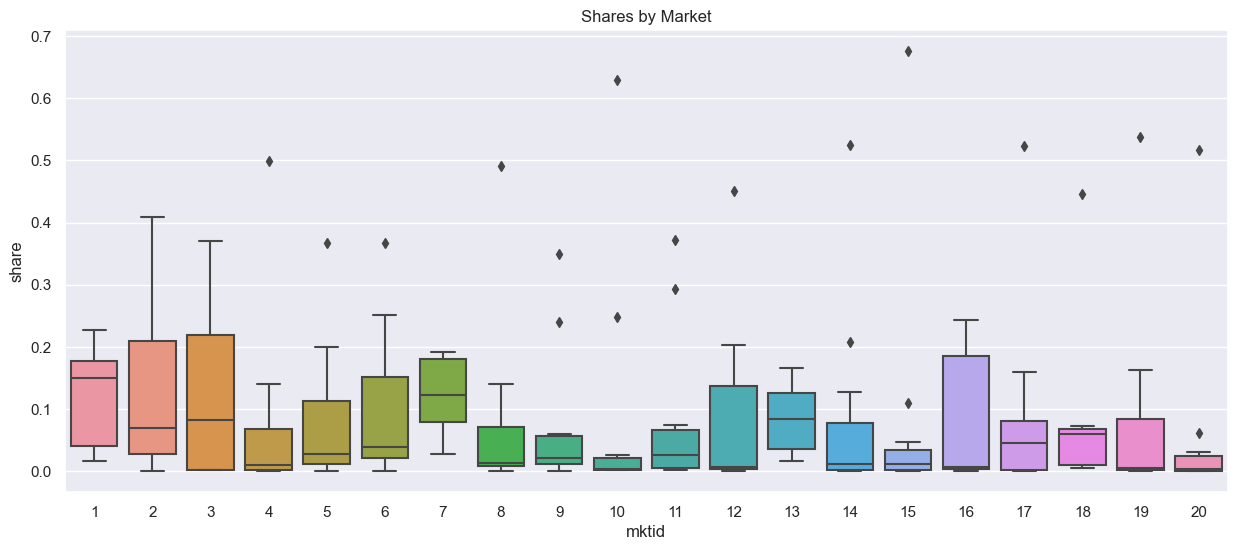

In [9]:
# Shares by Market
sns.boxplot(x="mktid", y="share",data=df.reset_index()).set(title='Shares by Market')
plt.savefig("sharesbymkt.png")

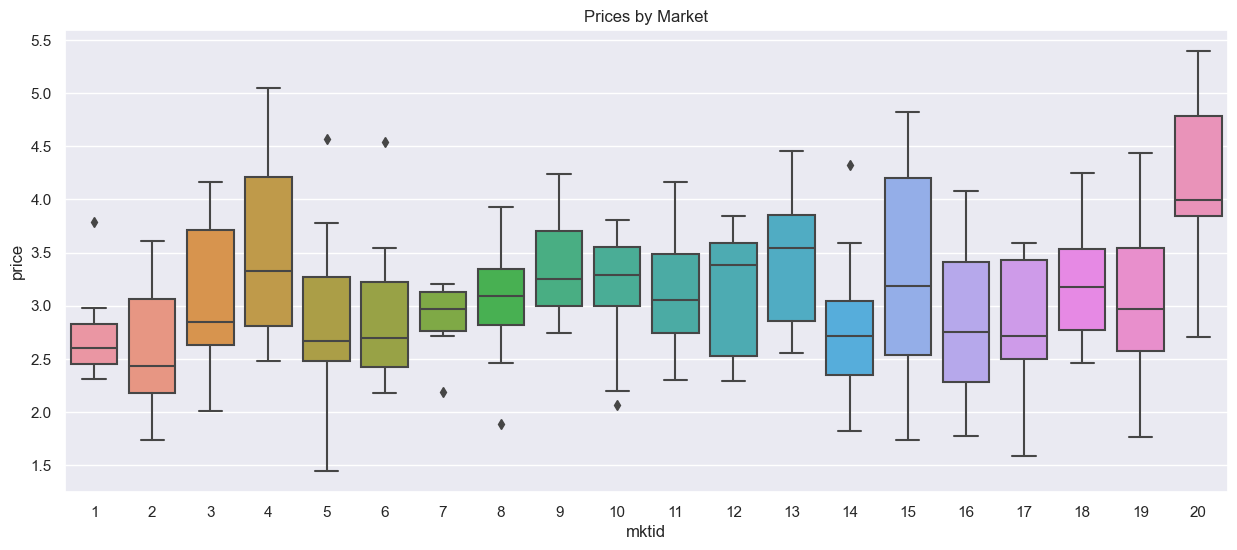

In [10]:
# Prices by Market
sns.boxplot(x="mktid", y="price",data=df.reset_index()).set(title='Prices by Market')
plt.savefig("pricesbymkt.png")

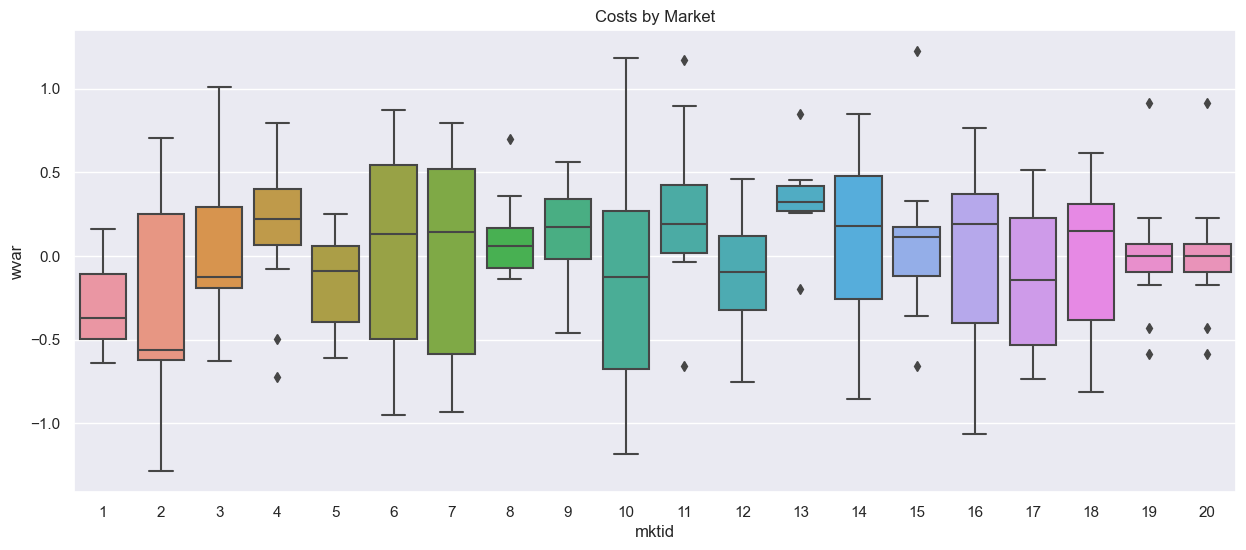

In [11]:
# Costs by Market
sns.boxplot(x="mktid", y="wvar",data=df.reset_index()).set(title='Costs by Market')
plt.savefig("costsbymkt.png")

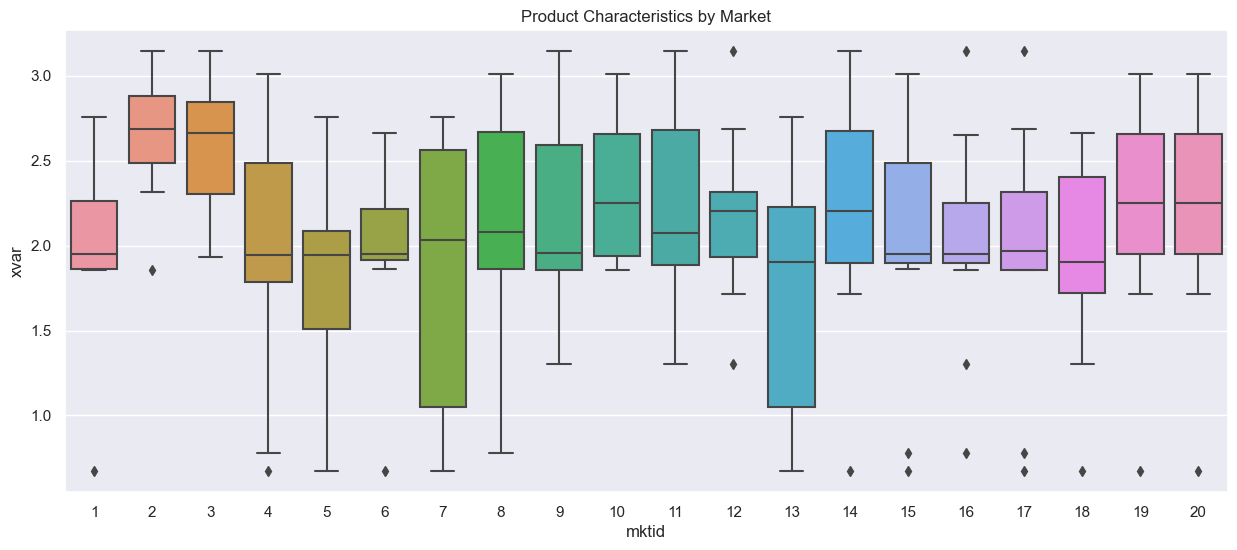

In [12]:
# Characteristics by Market
sns.boxplot(x="mktid", y="xvar",data=df.reset_index()).set(title='Product Characteristics by Market')
plt.savefig("xvarbymkt.png")

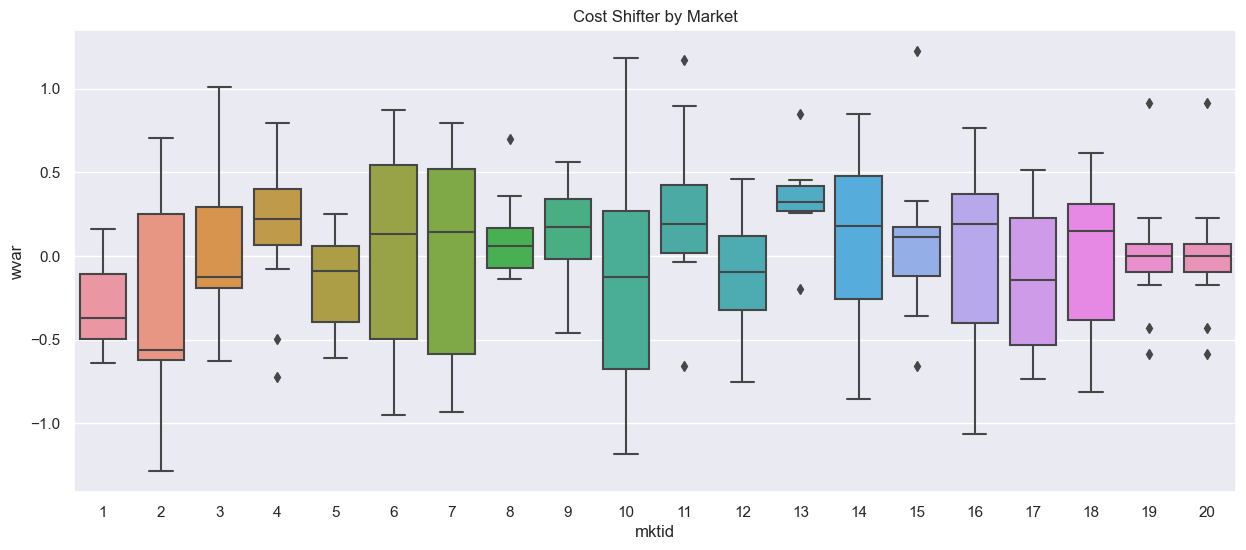

In [13]:
# Characteristics by Market
sns.boxplot(x="mktid", y="wvar",data=df.reset_index()).set(title='Cost Shifter by Market')
plt.savefig("wvarbymkt.png")

### Firm Summaries

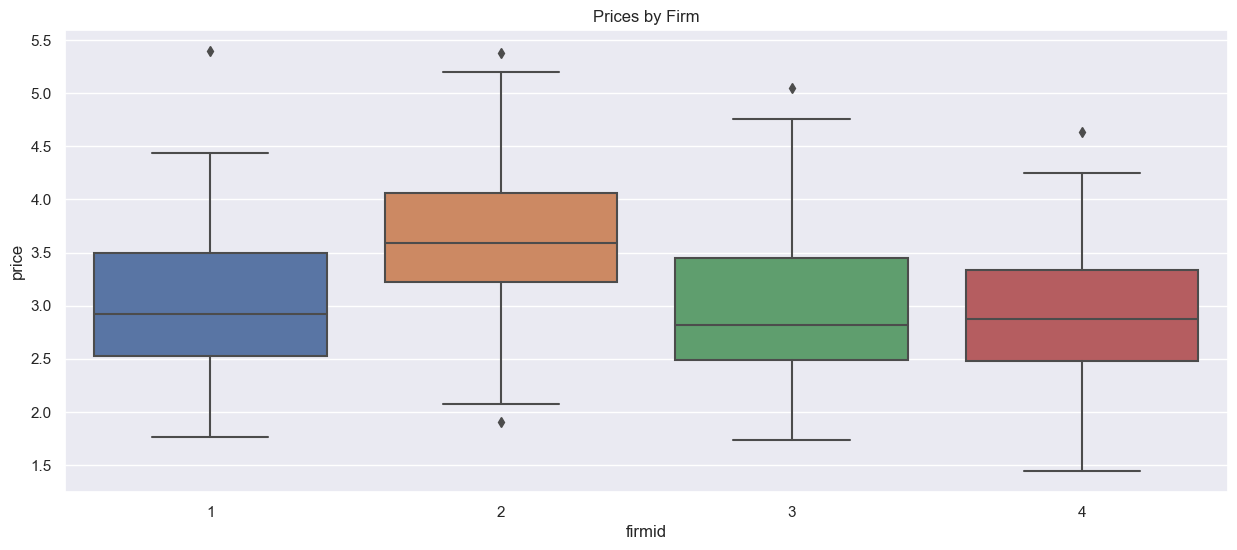

In [14]:
# Prices by Firm
sns.boxplot(x="firmid", y="price",data=df.reset_index()).set(title='Prices by Firm')
plt.savefig("pricesbyfirm.png")

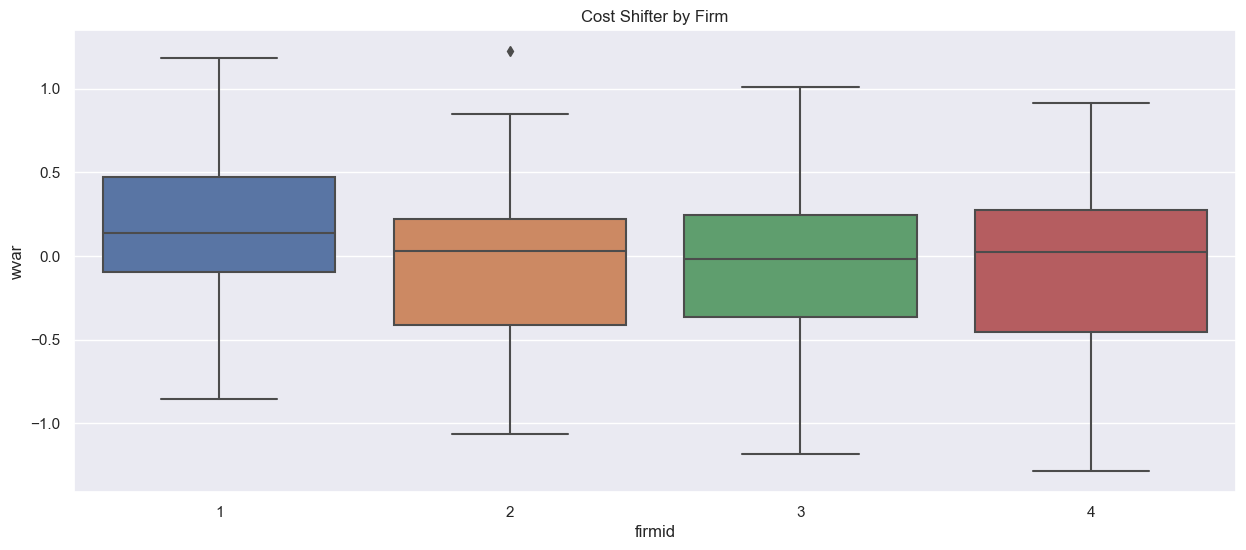

In [15]:
# Costs by Firm
sns.boxplot(x="firmid", y="wvar",data=df.reset_index()).set(title='Cost Shifter by Firm')
plt.savefig("costsbyfirm.png")

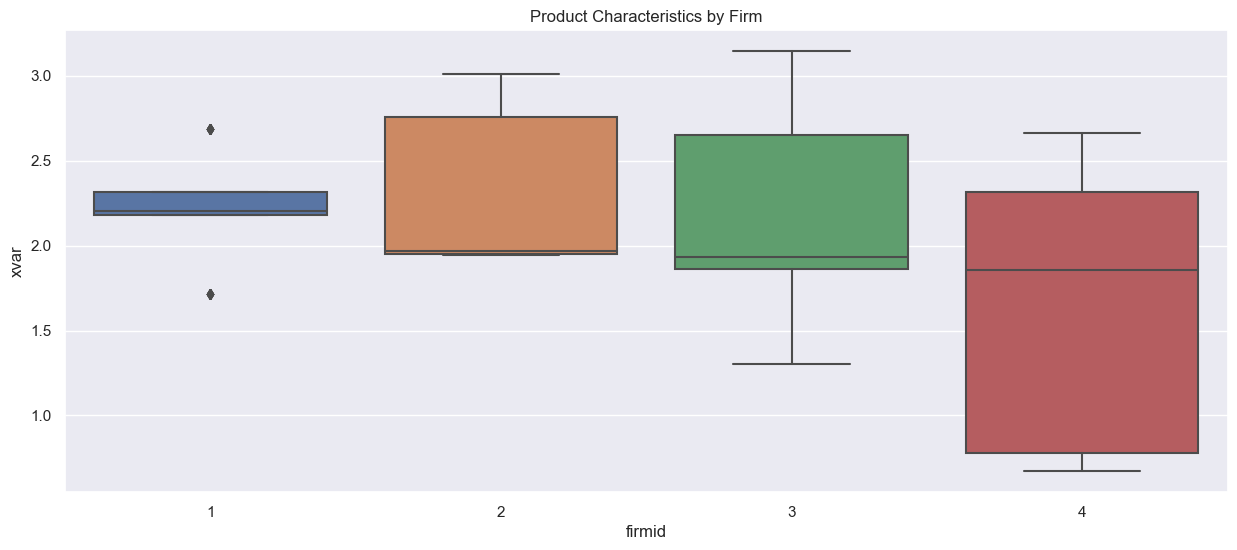

In [16]:
# Characteristics by Firm
sns.boxplot(x="firmid", y="xvar",data=df.reset_index()).set(title='Product Characteristics by Firm')
plt.savefig("xvarbyfirm.png")

### Product Summaries

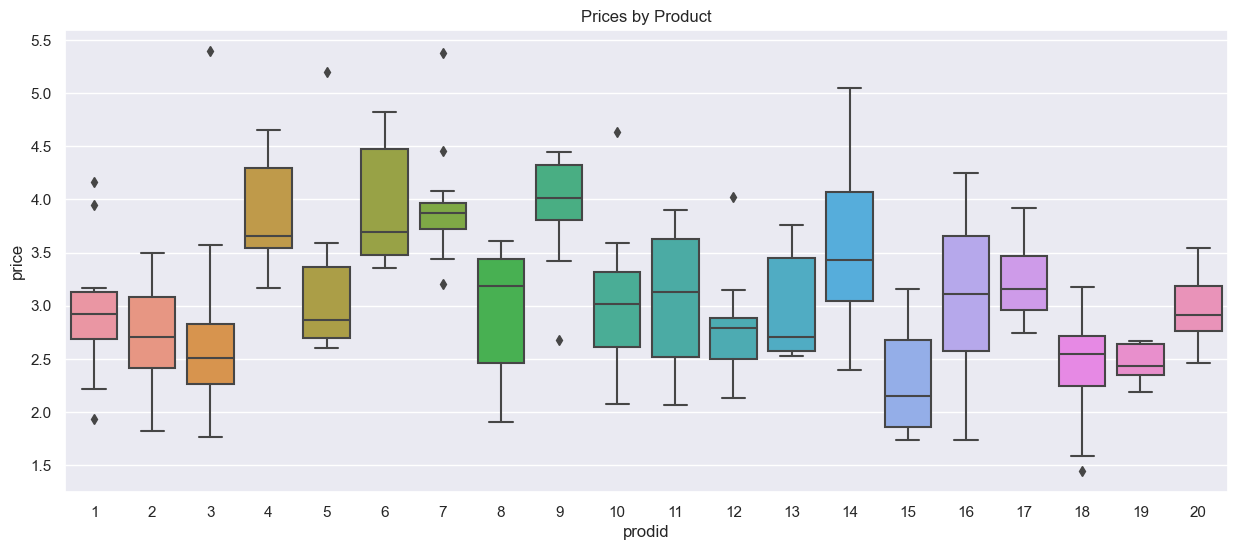

In [17]:
# Prices by Prod
sns.boxplot(x="prodid", y="price",data=df.reset_index()).set(title='Prices by Product')
plt.savefig("pricesbyprod.png")

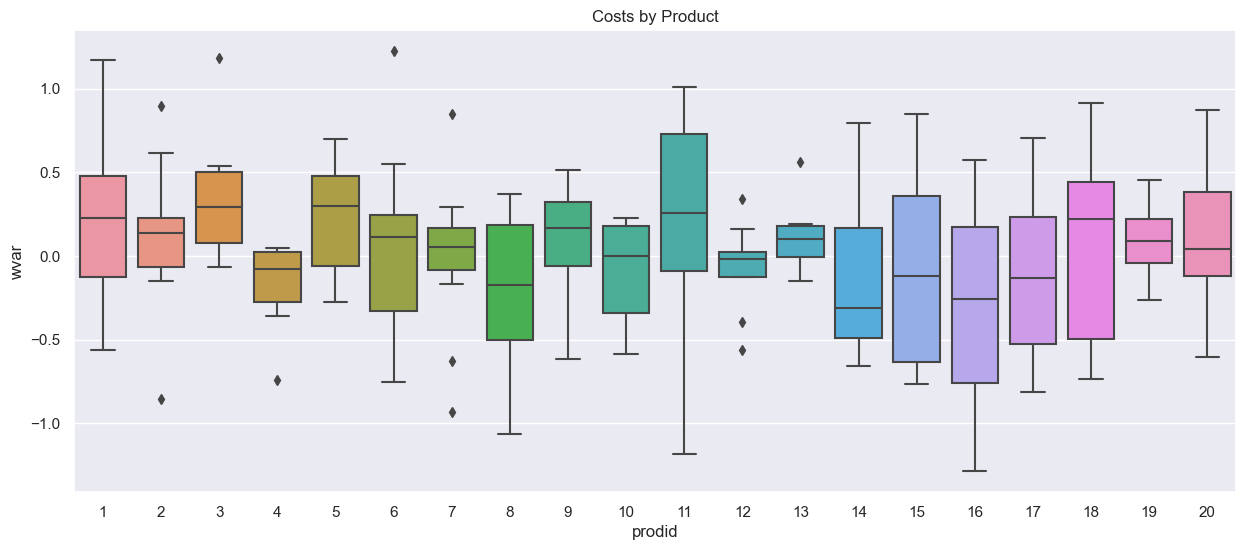

In [18]:
# Costs by Prod
sns.boxplot(x="prodid", y="wvar",data=df.reset_index()).set(title='Costs by Product')
plt.savefig("costsbyprod.png")

## Logit model warmup

In [19]:
import statsmodels.api as sm_

def run_2SLS(df:pd.DataFrame, instrument:list):
  Y = df["log_share"]
  X = sm_.add_constant(df[["price", "xvar"]])
  Z = sm_.add_constant(df[instrument + ["xvar"]])
  logit_2sls = IV2SLS(endog=Y,exog=X, instrument=Z).fit()
  constant, alpha, beta = logit_2sls.params
  print(logit_2sls.summary())
  return logit_2sls

def run_2SGMM(df:pd.DataFrame, instrument:list):
  Y = df["log_share"]
  X = sm_.add_constant(df[["price", "xvar"]])
  Z = sm_.add_constant(df[instrument + ["xvar"]])
  logit_2sgmm = IVGMM(endog=Y,exog=X,instrument=Z).fit();
  constant, alpha, beta = logit_2sls.params
  print(logit_2sgmm.summary())
  return logit_2sgmm

### OLS

In [20]:
df["log_share"] = np.log(df["share"])
logit_ols = sm.ols(formula="log_share ~ xvar + price", data=df).fit()
print(logit_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              log_share   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     340.1
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           1.07e-62
Time:                        14:09:49   Log-Likelihood:                -274.26
No. Observations:                 188   AIC:                             554.5
Df Residuals:                     185   BIC:                             564.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4678      0.360      4.073      0.0

eval_env: 1


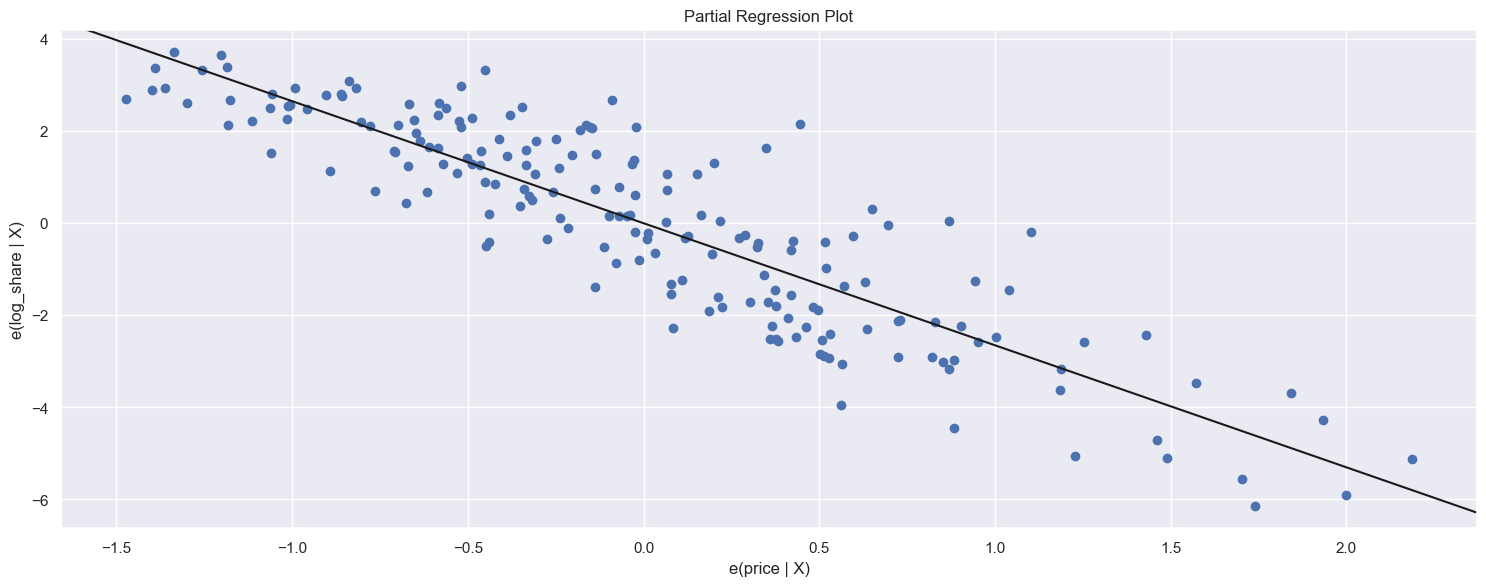

In [21]:
# Partial Regression Plot of logshare-E[logshare|xvar] on price-E[price|xvar]
import statsmodels.api as sm_
fig = sm_.graphics.plot_partregress("log_share", "price", ["xvar"], data=df, obs_labels = False)
fig.tight_layout(pad=1.0)

### 2SLS

In [22]:
logit_2sls = run_2SLS(df, ["wvar"])

                          IV2SLS Regression Results                           
Dep. Variable:              log_share   R-squared:                       0.785
Model:                         IV2SLS   Adj. R-squared:                  0.783
Method:                     Two Stage   F-statistic:                     86.48
                        Least Squares   Prob (F-statistic):           3.04e-27
Date:                Wed, 01 Feb 2023                                         
Time:                        14:09:50                                         
No. Observations:                 188                                         
Df Residuals:                     185                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6599      0.583      2.846      0.0

### GMM

3. With GMM: When we have strong instruments, GMM is more efficient than 2SLS under heteroskedasticity because computes the 'optimal weighing matrix' to weigh sample moments. 

In [23]:
logit_2sgmm = run_2SGMM(df, ["wvar"])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                                IVGMM Results                                 
Dep. Variable:              log_share   Hansen J:                    1.403e-11
Model:                          IVGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date: 

### Double Machine Learning 


$log(s)=αp+g(x)+e, E[e|x,w]=0$
 - Here $g$ is estimated by flexible machine learning methods
 - and $[x,w]$ are instruments

In [24]:
%pip install doubleml
from doubleml import DoubleMLData, DoubleMLPLIV
from sklearn.ensemble import RandomForestRegressor
l = RandomForestRegressor() # Model for E[Y|X] = E[θD+g(X)]
g = RandomForestRegressor() # Model for E[Y - θD|X]=g(X)
m = RandomForestRegressor() # Model for E[D|X]
data = DoubleMLData(df, y_col="log_share",d_cols=["price"], x_cols=["xvar"],z_cols=[ "wvar"])
DML = DoubleMLPLIV(data, l, m, g, n_folds=5, apply_cross_fitting=True)
DML.fit();
print(DML.summary)
import numpy as np
beta = np.array(DML.summary).reshape(-1).tolist()[0]


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
           coef  std err          t         P>|t|     2.5 %    97.5 %
price -2.768381  0.18785 -14.737181  3.719897e-49 -3.136561 -2.400202


### Why do we need Instruments? 

Let demand curve be: $q=βp+d$ where $d$ is a random demand shifter (e.g. random holiday). Since demand shifters are likely to effect price (as price and quantity determined simultaneously), $E[dp] \not= 0$. 

- $q=βp+d, E[dp] \not= 0 \implies β \not= E[x^2]^{-1}E[yx]$
- So $\hat{β}=(\sum_{i}x_{i}^2)^{-1}(\sum_{i}y_{i}x_{i})$ will not converge to $β$

But if we have access to a supply/cost shifter $c$ (e.g. weather) that is exogenous to demand,

- $c \perp d$ 
- $q=p+c$. 

We can solve for price to get: 

- $p= \theta_{1}c + \theta_{2}d$

Thus  $c$  will influence both price and quantity but be uncorrelated with demand shocks. 
- $E[dc] = 0, E[pc] \not=0 \implies β = E[xc]^{-1}E[yc]$

Thus these are the two conditions for $c$ to be a valid instrument: 
- (untestable) $E[dc] = 0$ 
- (testable) $E[pc] \not= 0$. 

Examples of other Instruments: 
- Cost shifters: marginal costs, wages, fixed costs, input prices, prices in other markets (Hausman)
- Markup shifters: product characteristics, entry/exit events, merger/collusion event, 

### Elasticities 

In [135]:
def get_logit_elasticities(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["price"].shape[0]
    print(N)
    mkt_elst = -alpha*np.dot(np.ones((N,1)), (df_mkt["price"]*df_mkt["share"]).to_numpy().reshape((1,N))) + alpha*np.diag(df_mkt["price"])
    return pd.DataFrame(mkt_elst, index=df_mkt.index, columns=df_mkt.index)

def get_demand_derivatives_logit(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["share"].shape[0]
    #dqdp = np.dot(df_mkt["share"],(1-df_mkt["share"])) - alpha*np.ones((N,1)) + alpha*np.diag(df_mkt["share"]*df_mkt["share"])
    dqdp = np.array(-alpha*np.outer(df_mkt["share"],df_mkt["share"]))
    diag = list(alpha*df_mkt["share"]*(1-df_mkt["share"]))
    np.fill_diagonal(dqdp, diag)
    return dqdp

In [136]:
get_demand_derivatives_logit(1)

array([[-0.47963682,  0.0098976 ,  0.10876187,  0.09268852,  0.11125919,
         0.02197229,  0.02909848],
       [ 0.0098976 , -0.04286171,  0.0076324 ,  0.00650445,  0.00780765,
         0.00154191,  0.002042  ],
       [ 0.10876187,  0.0076324 , -0.39475717,  0.07147552,  0.08579605,
         0.01694364,  0.02243891],
       [ 0.09268852,  0.00650445,  0.07147552, -0.34698106,  0.0731167 ,
         0.01443962,  0.01912278],
       [ 0.11125919,  0.00780765,  0.08579605,  0.0731167 , -0.40185134,
         0.01733269,  0.02295414],
       [ 0.02197229,  0.00154191,  0.01694364,  0.01443962,  0.01733269,
        -0.09327026,  0.00453315],
       [ 0.02909848,  0.002042  ,  0.02243891,  0.01912278,  0.02295414,
         0.00453315, -0.12205008]])

Matrix of own and cross-price elasticities for market 1:

In [27]:
get_logit_elasticities(4)

11


firmid                1                               2                    3  \
prodid               1         2          4          6          9         11   
firmid prodid                                                                  
1      1      -7.233376  0.088745   0.016764   0.005128   0.026804  3.380371   
       2       1.186560 -8.996762   0.016764   0.005128   0.026804  3.380371   
       4       1.186560  0.088745 -11.338957   0.005128   0.026804  3.380371   
2      6       1.186560  0.088745   0.016764 -11.644522   0.026804  3.380371   
       9       1.186560  0.088745   0.016764   0.005128 -12.121171  3.380371   
3      11      1.186560  0.088745   0.016764   0.005128   0.026804 -3.402418   
       14      1.186560  0.088745   0.016764   0.005128   0.026804  3.380371   
4      16      1.186560  0.088745   0.016764   0.005128   0.026804  3.380371   
       17      1.186560  0.088745   0.016764   0.005128   0.026804  3.380371   
       18      1.186560  0.088745   0.016764   0.005128   0.026804  3.380371   
       19      1.186560  0.088745   0.016764   0.005128   0.026804  3.380371   

firmid                           4                                 
prodid                14        16         17        18        19  
firmid prodid                                                      
1      1        0.000609  0.913498   0.020115  0.145107  0.084013  
       2        0.000609  0.913498   0.020115  0.145107  0.084013  
       4        0.000609  0.913498   0.020115  0.145107  0.084013  
2      6        0.000609  0.913498   0.020115  0.145107  0.084013  
       9        0.000609  0.913498   0.020115  0.145107  0.084013  
3      11       0.000609  0.913498   0.020115  0.145107  0.084013  
       14     -13.795075  0.913498   0.020115  0.145107  0.084013  
4      16       0.000609 -7.010241   0.020115  0.145107  0.084013  
       17       0.000609  0.913498 -10.300239  0.145107  0.084013  
       18       0.000609  0.913498   0.020115 -7.259410  0.084013  
       19       0.000609  0.913498   0.020115  0.145107 -7.109152

In [28]:
# export elasticities (question 5)
matrix_elasticities = get_logit_elasticities(4)

with open('table_5.tex','w') as tf:
    tf.write(matrix_elasticities.to_latex())
    tf.close()

11


/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_1333/2073041566.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(matrix_elasticities.to_latex())


### Hausman Instruments

Hausman instrument uses prices from other cities when cost data is unavailable. Let $i$ index cities,

$p_{i}= \theta_{1}c_{i} + \theta_{2}d_{i}$

Then $p_{-i}$ can be a valid instrument for $p_{i}$ when,

(1) $c_{i}$ is a valid instrument for $p_{i}$

(2) $E[c_{-i}c_{i}] \not=0$: Costs accross cities have a common factor.

(2) $E[d_{-i}d_{i}] =0$: Demand innovations accross cities have no common factor and are uncorrelated. 

**Hausman (1994)**

"However, at the lower levels where consumers choose among brands, the search for instruments is more difficult since excluded **cost shifting variables at the
brand level may be difficult to find**, depending on the given situation...Our approach is to allow for both individual brand fixed effects and city fixed effects, and then to use the prices from one city as instruments for other cities ...The intuition that we use is that prices in each city reflect underlying product costs and city
specific factors which vary over time as supermarkets run promotions on a particular product. To the extent that the stochastic city specific factors are independent of each other, prices from one city can serve as instruments
for another city."

$i$: brand, $n$: city, $t$: period, $s_{int}$:revenue share of total segment expenditure, $y_{Gnt}$:segment expenditure, $P_{nt}$:price index, $p_{jnt}$: price, $c_{jt}$:cost, $α_{jn}$:city-specific transport and wage differential, $w_{jnt}$: offers/discounts. 

(1) Demand: $s_{int}=α_{in}+β_{i}log(y_{Gnt}/P_{nt}+\sum_{j} γ_{ij}log(p_{jnt})+e_{int}$

(4) Pricing: $log(p_{jnt})=δ_{j}log(c_{jt})+α_{jn}+w_{jnt}$

"The specific identifying assumption that we make is
that the $w_{jnt}$ are independent across cities...The idea is that prices in one city (after elimination of city
and brand specific effects) are driven by underlying costs, $c_{it}$, which provide instrumental variables which are correlated with prices but are
uncorrelated with stochastic disturbances in the demand equations, e.g.,
$w_{jnt}$ from equation (4) is uncorrelated with $e_{ilt}$ from equation (1) when the cities are different, $n \not= l$."

In [29]:
def make_hausman_instr(df: pd.DataFrame) -> pd.DataFrame:
    hausman_ivs = {}
    for mktid, df_mkt in df.groupby(by="mktid"):
        df_othermkts = df[~df.index.get_level_values('mktid').isin([mktid])]
        hausman_priceavg = df_othermkts.groupby(by=["firmid", "prodid"])["price"].mean()
        hausman_priceavg = pd.concat([hausman_priceavg], keys=[mktid], names=['mktid'])
        hausman_ivs[mktid] = hausman_priceavg
    return pd.concat(hausman_ivs.values(), keys=hausman_ivs.keys()).rename('hausman_iv').droplevel(0)

In [30]:
hausman_ivs = make_hausman_instr(df)
df = pd.merge(left=df, right=hausman_ivs, on=df.index.names)

In [31]:
logit_2sls_hausman = run_2SLS(df, ["hausman_iv"])

                          IV2SLS Regression Results                           
Dep. Variable:              log_share   R-squared:                       0.784
Model:                         IV2SLS   Adj. R-squared:                  0.781
Method:                     Two Stage   F-statistic:                     97.55
                        Least Squares   Prob (F-statistic):           2.23e-29
Date:                Wed, 01 Feb 2023                                         
Time:                        14:09:57                                         
No. Observations:                 182                                         
Df Residuals:                     179                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3328      0.592      3.941      0.0

### BLP IVs

BLP propose using:

*   (1) Own characteristics
*   (2) Sum of characteristics of other products produced by the firm
*   (3) Sum of characteristics of competitors products

For these instruments to be valid we need observed characteristics to be mean independent of unobserved characteristics. Assumes each attribute is exogenous.

In [32]:
def BLPIV(df):
  df3 = df.reset_index()
  T = len(df3.mktid.unique())
  J = len(df3.prodid.unique())
  N = len(df3.firmid.unique())
  D1 = np.zeros((N,T))
  D2 = np.zeros((N,T))
  D3 = np.zeros((N,J,T))
  D4 = np.zeros((N,J,T))

  for t in range(1, 21):
    for n in range(1, 5):

      # BLP1: Number of products owned by competing firm
      D1[n-1,t-1] = len(df3[(df3.firmid!=n) & (df3.mktid==t)].prodid.unique())
      
      # BLP2: Total number of products by market (co-linear in these data)
      D2[n-1,t-1] = len(df3[(df3.mktid==t)].prodid.unique())
  
  for t in range(1, 21):
    for n in range(1, 5):
      for j in range(1, 21):

        # BLP3: Sum of attributes in the market for each product produced by firm excluding product j
        D3[n-1,j-1,t-1] = df3[(df3.firmid==n) & (df3.mktid==t) & (df3.prodid!=j)].xvar.sum()
        
        # BLP4: Sum of attributes of products owned by competing firm
        D4[n-1,j-1,t-1] = df3[(df3.firmid!=n) & (df3.mktid==t) & (df3.prodid!=j)].xvar.sum()

  # write the D matrices (4,20) back into the dataframe indexed by firmid, mktid
  df3['blp1']=0
  df3['blp2']=0
  df3['blp3']=0
  df3['blp4']=0

  for t in range(1, 21):
    for n in range(1, 5):

      df3.loc[(df3.mktid==t) & (df3.firmid==n),'blp1'] = D1[n-1,t-1]
      df3.loc[(df3.mktid==t) & (df3.firmid==n),'blp2'] = D2[n-1,t-1]

  for t in range(1, 21):
    for n in range(1, 5):
      for j in range(1, 21):

        df3.loc[(df3.mktid==t) & (df3.firmid==n) & (df3.prodid==j),'blp3'] = D3[n-1,j-1,t-1]
        df3.loc[(df3.mktid==t) & (df3.firmid==n) & (df3.prodid==j),'blp4'] = D4[n-1,j-1,t-1]

  df3 = df3.set_index(['mktid', 'prodid', 'firmid'])
  return df3

### Differentiation IVs

- For $p_{jt}$ we construct the following instruments: 
- (1) Own product characteristic: $x_{jt}$
- (2) Other Product distance: $\sum_{k \not= j} d_{jkt}= \sum_{k \not= j} (d_{jt} - d_{kt})^2$
- (3) No. of products within range: $\sum_{k \not= j} 1(|d_{jkt}|<\tau)$

"A folk wisdom that has been “in the air” since BLP is that the correlation between a product’s market share and the entry and exit of products with more or less similar characteristics provide the identifying variation for substitution patterns in mixed logit models. " 

"We refer to this sufficient statistic as the “local market structure” facing a product, which takes the form of the empirical distribution of differences in product characteristics between a given product and its competitors."


In [33]:
def differentiationIV(df):
    df2 = df.reset_index()
    T = len(df2.mktid.unique())
    N = len(df2.firmid.unique())
    J = len(df2.prodid.unique())
    D = np.zeros((J,J,T))

    for j in range(J):
        for k in range(J):
            for t in range(T):
                try:
                    D[j,k,t] = df2[(df2.prodid==j) & (df2.mktid==t)].xvar.item() - df2[(df2.prodid==k) & (df2.mktid==t)].xvar.item() 
                except: 
                    D[j,k,t] = 0

    D2 = D**2

    df2['prod_char_dist']=0
    for t in range(T):
        for j in range(J):
            temp = 0
            for k in range(J):
                if k != j:
                    temp += D2[j, k, t]**2
            df2.loc[(df2.mktid==t) & (df2.prodid==j),'prod_char_dist'] = temp

    df2['prod_band0']=0
    df2['prod_band1']=0
    df2['prod_band2']=0
    for t in range(T):
        for j in range(J):
            q_2 = np.quantile(np.abs(D[j,:,t]), 0.5)
            q_5 = np.quantile(np.abs(D[j,:,t]), 0.75)
            q_7 = np.quantile(np.abs(D[j,:,t]), 0.95)
            #print(q_2, q_5, q_7)
            for (i,q) in enumerate([q_2, q_5, q_7]):
                temp = 0
                for k in range(J):
                    if k != j:
                        if np.abs(D2[j, k, t]) < q:
                            temp += 1
                name = 'prod_band' + str(i)
                df2.loc[(df2.mktid==t) & (df2.prodid==j), name] = temp
                
    print(np.mean(df2['prod_char_dist']), np.mean(df2.prod_band0), np.mean(df2.prod_band1), np.mean(df2.prod_band2))
    df2 = df2.set_index(['mktid', 'prodid', 'firmid'])
    df2 = df2.fillna(0)
    df2.rename(columns={'prod_char_dist': 'diff_iv', 'prod_band0': 'diff_iv_prodband0', 'prod_band1': 'diff_iv_prodband1', 'prod_band2': 'diff_iv_prodband2'}, inplace=True)
    return df2

In [34]:
df = differentiationIV(df)

14.562190736471745 3.2527472527472527 13.873626373626374 15.81868131868132


In [35]:
df = BLPIV(df)

## Random Coefficients Logit Model

In [37]:
us_census = pd.read_csv("census-ageincome-joint-small.csv", index_col=0).astype(int)
census_density = (1./us_census.sum().sum())*us_census
n_age, n_inc = us_census.shape

In [38]:
def draw_from_census(n:int, normalize:bool=True) -> pd.DataFrame:
    census_distr = multinomial(n=1, p=census_density.to_numpy().flatten())
    census_draws = census_distr.rvs(n)
    dem_ids = np.array([np.argwhere(census_draws[k,:].reshape(n_age, n_inc))[0] for k in range(census_draws.shape[0])]).astype(float)
    if normalize:
        dem_ids[:,0] = dem_ids[:,0]/(n_age-1)
        dem_ids[:,1] = dem_ids[:,1]/(n_inc-1)
    return pd.DataFrame.from_dict({'age': dem_ids[:,0], 'income': dem_ids[:,1]})

def draw_from_normal(n: int) -> pd.DataFrame:
    return pd.DataFrame.from_dict({'age': norm.rvs(loc=0, scale=1, size=n), 'income': norm.rvs(loc=0, scale=1, size=n)})

def simulate_consumers(n:int=500, scale:float=1, sample_demographics:str='norm') -> pd.DataFrame:
    cons_df = pd.Series(data=gumbel_r.rvs(scale=scale, size=n), name='eps')
    if sample_demographics=='norm':
        demographics = draw_from_normal(n)
    elif sample_demographics=='census':
        demographics = draw_from_census(n)
    cons_df = pd.concat([cons_df, demographics], axis=1)
    return cons_df

In [162]:
cons = simulate_consumers(n=30)

In [163]:
def MC_share_estimation(delta_est:pd.Series, mu_est:pd.DataFrame):
    """
    Implements a Monte-Carlo estimator of sigma_{jt}
    delta_est must be a Series indexed by the same MultiIndex((cdid,prodid)) as df
    """
    # assert_index_equal(delta_est.index, mu_est.index)

    normlzr = 1 + np.exp(mu_est.add(delta_est, axis='index')).groupby(by='mktid').sum()
    return np.exp(mu_est.add(delta_est, axis='index')).divide(
        normlzr,
        axis='index'
    ).mean(axis=1)


class NFP(GMM):
    """
    Implements the nested fixed-point method
    Arguments:
        mkt_df: pd.DataFrame at the mkt*prod*firm level containing data, including instruments to be used for 2SLS
        cons: pd.DataFrame containing consumer data
        instruments: list of field names from mkt_df to use as instruments in the 2SLS process
        theta2_0: initial guess of theta2
        tol_fp: tolerance on the variation on mean variation used to stop the fixed-point iteration
        tol_ol: tolerance on the variation of theta=(theta1, theta2) used to stop the outer-loop of the algorithm
    Returns:
        theta_1: np.array
        theta_2: np.array
        dmd_s
    """
    def __init__(self, mkt_df: pd.DataFrame, cons: pd.DataFrame, instruments: list, tol_fp: float=1e-6, tol_gmm: float=1e-6, verbose=False):
        endog = mkt_df["log_share"]
        exog = mkt_df[["price", "xvar"]]
        instrument = mkt_df[instruments + ["xvar"]]
        super(NFP,self).__init__(endog, exog, instrument, k_moms=2+len(instruments), k_params=2)
        self.mkt_data = mkt_df.copy()
        self.cons_data  = cons.copy()
        self.tol_fp = tol_fp
        self.xtol = [tol_gmm, tol_gmm]

        self.X = sm_.add_constant(self.mkt_data[["price", "xvar"]])
        self.instrument_list = instruments
        self.Z = sm_.add_constant(self.mkt_data[self.instrument_list + ["xvar"]])

        # Compute weighting matrix
        self.inv_weights = np.dot(self.Z.T,self.Z)

        self.verbose = verbose

    def mean_val_guess(self, instrument='wvar'):
        """
        Returns a pd.Series at the scale of mkt*prod (no firms!)
        """
        delta_est = {}
        for mktprod, df_mktprod in self.mkt_data.groupby(by=['mktid', 'prodid']):
            #logit_2sls0 = run_2SLS(df_mktprod, ["wvar"])
            logit_ols0 = sm.ols(formula="log_share ~ price + xvar", data=df).fit()
            constant, alpha, beta = logit_ols0.params
            #alpha, beta = IV2SLS(endog=df_mktprod["log_share"], exog=df_mktprod[["price", "xvar"]], instrument=df_mktprod[[instrument, "xvar"]]).fit()
            delta_est[mktprod] = (constant+alpha*df_mktprod["price"]+beta*df_mktprod["xvar"]).iloc[0]
        return pd.Series(delta_est).rename_axis(index=['mktid', 'prodid'])

    def idiosyncratic_coefs(self, theta2: np.array):
        """Computes Pi*D"""
        Pi = np.array([[theta2[0],0],[0,0],[0,theta2[1]]])
        return np.dot(self.cons_data[['age','income']].to_numpy(), Pi.T)

    def idiosyncratic_valuations(self, theta2: np.array):
        is_val_est = self.idiosyncratic_coefs(theta2)
        cust_vals = np.dot(self.X.to_numpy(),is_val_est.T)
        return pd.DataFrame(cust_vals, index=self.mkt_data.index, columns=["cust{0:d}".format(k) for k in range(is_val_est.shape[0])])

    def NFP_contr_map(self, expdel, is_vals):
        return expdel*self.mkt_data["share"]/MC_share_estimation(np.log(expdel), is_vals)

    def est_delta(self, delta0:pd.Series, is_vals:pd.DataFrame, tol:float=1e-6):
        """
        Iterates the contraction mapping until the error between shares and share estimates
        is smaller than tol, for the standard euclidean distance, with the sampling measure.
        """
        assert tol>0
        expdel = delta0.apply(np.exp)

        while True:
            expdel_next = self.NFP_contr_map(expdel, is_vals)
            err = np.linalg.norm(expdel_next - expdel, np.Inf)
            if err < tol:
                break
            expdel = expdel_next

        return np.log(expdel)

    def momcond(self, theta2: np.array):
        """
        Generates the empirical loss corresponding to the outer-loop GMM
        of the Nested-Fixed Point algorithm
        Arguments:
            theta_2: estimated value of idiosyncratic valuation parameters
        Returns:
            1. Empirical loss on moment conditions
            2. Estimation of coefficients for the mean valuation
            3. Estimation of demand shifters
        """
        if self.verbose:
            print("momcond evaluation at theta2=({0:.2e},{1:.2e})".format(theta2[0], theta2[1]))
        # 1. From an estimate of theta2, recover the idiosyncratic valuations
        is_vals = self.idiosyncratic_valuations(theta2)

        # 2. From an initial guess of mean valuations from a "Step 0" IV, call the Fixed-Point procedure
        # until convergence to estimate mean valuations delta
        if hasattr(self, "delta"):
            delta0 = self.delta
        else:
            delta0 = self.mean_val_guess()
        self.delta = self.est_delta(delta0, is_vals, tol=self.tol_fp)

        # 3. Use 2SLS to estimate theta1
        tsls = IV2SLS(endog=self.delta, exog=self.X, instrument=self.Z).fit()
        self.theta1_est = tsls.params
        self.dmd_shifters = tsls.resid

        #4. Recover empirical loss function
        self.moms = np.dot(self.Z.T, self.dmd_shifters.T).reshape([1,self.nmoms])
        return self.moms
    
    def fit(self, *args, **kwargs):
        gmmres = super(NFP, self).fit(*args,inv_weights=self.inv_weights,**kwargs)
        results = {
            'theta1_est': self.theta1_est,
            'theta2_est': gmmres.params,
            'dmdshift_est': self.dmd_shifters,
            'mu_est': self.idiosyncratic_valuations(gmmres.params),
            'delta_est': self.delta,
            'moms': self.moms,
        }
        return results
    

In [164]:
#nfp = NFP(df, cons, instruments=["hausman_iv", "diff_iv", "diff_iv_prodband0", "diff_iv_prodband1", "diff_iv_prodband2", "wvar"], tol_fp=1e-4)
nfp = NFP(df, cons, instruments=["wvar", "hausman_iv"], tol_fp=1e-4)

theta2_0=np.random.rand(1,2)

In [165]:
nfp.verbose = False
nfp_res = nfp.fit(theta2_0, optim_method="nm", maxiter=0)

KeyboardInterrupt: 

In [168]:
df2['share']/grou

,,,price,share,xvar,wvar,log_share,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,blp1,blp2,blp3,blp4,mc,mc2,upp,p2,ti
prodid,firmid,mktid,,,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,5.610647,0,17,18,6,7,0.000000,11.416658,2.132906,2.632906,0.5,2.632906,0.026231
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,20.700417,0,15,18,5,7,1.952670,8.910361,3.330649,3.830649,0.5,3.830649,0.047353
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,3.129697,0,16,18,5,7,2.755761,8.910361,2.045528,2.545528,0.5,2.545528,0.047353
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,2.697010,0,15,18,6,7,0.000000,11.758187,1.965669,2.465669,0.5,2.465669,0.069618
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,7.487307,0,15,18,4,7,2.529646,8.771171,2.187259,2.687259,0.5,2.687259,0.004226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1,20,2.708315,0.515946,2.181564,-0.065767,-0.661754,2.738265,0.000000,0,0,0,3,6,4.034082,6.930525,1.944970,2.444970,0.5,2.444970,-0.263345
3,1,20,5.394167,0.000116,2.316431,0.043551,-9.066113,2.483354,0.000000,0,0,0,3,6,3.899215,6.930525,4.630821,5.130821,0.5,5.130821,-0.263345
6,2,20,3.677919,0.012641,1.952670,-0.428108,-4.370777,3.963566,0.000000,0,0,0,3,6,4.977855,6.215646,3.281993,3.781993,0.5,3.781993,0.104074


In [167]:
theta1_est =5.355871
alpha=  -3.215760
beta=  1.964096
theta2_est = np.array([1.91774766, 0.66726286])
invsigma = df2['logsharedf2["xvar"]*beta+alpha*df2["price"]


In [ ]:

def get_demand_derivatives_logit(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["share"].shape[0]
    #dqdp = np.dot(df_mkt["share"],(1-df_mkt["share"])) - alpha*np.ones((N,1)) + alpha*np.diag(df_mkt["share"]*df_mkt["share"])
    dqdp = np.array(-alpha*np.outer(df_mkt["share"],df_mkt["share"]))
    diag = list(alpha*df_mkt["share"]*(1-df_mkt["share"]))
    np.fill_diagonal(dqdp, diag)
    return dqdp



def get_demand_derivatives_RCL(mktid: int) -> pd.DataFrame:
    constant =5.355871
    alpha =  -3.215760
    beta =  1.964096
    theta2_est = np.array([1.91774766, 0.66726286])
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    invsigma = df_mkt["xvar"]+
    
    N = df_mkt["share"].shape[0]
    #dqdp = np.dot(df_mkt["share"],(1-df_mkt["share"])) - alpha*np.ones((N,1)) + alpha*np.diag(df_mkt["share"]*df_mkt["share"])
    dqdp = np.array(-alpha*np.outer(df_mkt["share"],df_mkt["share"]))
    diag = list(alpha*df_mkt["share"]*(1-df_mkt["share"]))
    np.fill_diagonal(dqdp, diag)
    return dqdp

## Supply Side Inference

In [137]:
get_demand_derivatives_logit(4)

array([[-3.30674180e-01,  3.75978467e-03,  5.68233414e-04,
         1.69423914e-04,  8.49313739e-04,  1.91833335e-01,
         1.69788224e-05,  4.43757209e-02,  7.50224170e-04,
         7.54328859e-03,  4.49566670e-03],
       [ 3.75978467e-03, -2.64191678e-02,  3.93859029e-05,
         1.17432619e-05,  5.88683939e-05,  1.32965238e-02,
         1.17685133e-06,  3.07580968e-03,  5.20002090e-05,
         5.22847169e-04,  3.11607673e-04],
       [ 5.68233414e-04,  3.93859029e-05, -4.02628271e-03,
         1.77481276e-06,  8.89704900e-06,  2.00956431e-03,
         1.77862912e-07,  4.64861153e-04,  7.85902887e-06,
         7.90202785e-05,  4.70946896e-05],
       [ 1.69423914e-04,  1.17432619e-05,  1.77481276e-06,
        -1.20171811e-03,  2.65273534e-06,  5.99169711e-04,
         5.30314302e-08,  1.38602542e-04,  2.34324029e-06,
         2.35606082e-05,  1.40417061e-05],
       [ 8.49313739e-04,  5.88683939e-05,  8.89704900e-06,
         2.65273534e-06, -6.01350846e-03,  3.00360827e-03,
  

In [ ]:
# export elasticities (question 12)
matrix_elasticities = get_logit_elasticities(4)

with open('table_12.tex','w') as tf:
    tf.write(matrix_elasticities.to_latex())
    tf.close()

7


### Marginal Costs

In [139]:
def ownership(mktid):
    "input: market id, demand derivative matrix"
    "output: ownership matrix"
    dqdp = get_logit_elasticities(mktid)
    dqdp = dqdp.reset_index()
    F = dqdp.firmid.unique()
    J = dqdp.prodid.unique()
    Ω = np.zeros((len(J),len(J)))
    for ji,j in enumerate(J):
        for ki,k in enumerate(J):
            if dqdp[dqdp.prodid==j].firmid.item() == dqdp[dqdp.prodid==k].firmid.item(): 
                Ω[ji,ki] = 1
    return Ω
ownership(1)

7


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1.]])

In [140]:
def imputeMaginalCost(df):
    df2 = df.reset_index()
    M = df2.mktid.unique()
    df2['mc']=0
    for mi,m in enumerate(M):
        dqdp = get_demand_derivatives_logit(m)
        prodid = df2[df2.mktid==m]['prodid']
        firmid = df2[df2.mktid==m]['firmid']
        p = df2[df2.mktid==m]['price']
        s = df2[df2.mktid==m]['share']
        Ω = ownership(m)
        c = p + np.dot(np.linalg.inv(Ω*dqdp.T),s)
        df2.loc[(df2.mktid==m), 'mc']=c
    df2 = df2.set_index(['prodid', 'firmid', 'mktid'])
    return df2
df2 = imputeMaginalCost(df)
df2.head()

7
7
7
11
11
8
6
12
10
10
10
9
6
11
11
11
9
8
12
6


,,,price,share,xvar,wvar,log_share,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,blp1,blp2,blp3,blp4,mc
prodid,firmid,mktid,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,5.610647,0,17,18,6,7,0.000000,11.416658,2.132906
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,20.700417,0,15,18,5,7,1.952670,8.910361,3.330649
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,3.129697,0,16,18,5,7,2.755761,8.910361,2.045528
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,2.697010,0,15,18,6,7,0.000000,11.758187,1.965669
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,7.487307,0,15,18,4,7,2.529646,8.771171,2.187259


In [142]:
df2.mc

prodid  firmid  mktid
5       1       1        2.132906
7       2       1        3.330649
8       2       1        2.045528
14      3       1        1.965669
16      4       1        2.187259
                           ...   
2       1       20       1.944970
3       1       20       4.630821
6       2       20       3.281993
7       2       20       4.981475
8       2       20       2.892025
Name: mc, Length: 182, dtype: float64

### Tax analysis

In [144]:
df2['mc2'] = df2['mc']+0.5
def UPP(df):    
    df2 = df.reset_index()
    M = df2.mktid.unique()
    df2['upp']=0
    for mi,m in enumerate(M):
        dqdp = get_demand_derivatives_logit(m)
        prodid = df2[df2.mktid==m]['prodid']
        firmid = df2[df2.mktid==m]['firmid']
        p = df2[df2.mktid==m]['price']
        s = df2[df2.mktid==m]['share']
        c = df2[df2.mktid==m]['mc2']
        Ω = ownership(m)
        df2.loc[(df2.mktid==m), 'upp']=-p+c-np.dot(np.linalg.inv(Ω*dqdp.T),s)
    df2 = df2.set_index(['prodid', 'firmid', 'mktid'])
    return df2
df2 = UPP(df2)
df2.head()

7
7
7
11
11
8
6
12
10
10
10
9
6
11
11
11
9
8
12
6


,,,price,share,xvar,wvar,log_share,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,blp1,blp2,blp3,blp4,mc,mc2,upp
prodid,firmid,mktid,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,5.610647,0,17,18,6,7,0.000000,11.416658,2.132906,2.632906,0.5
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,20.700417,0,15,18,5,7,1.952670,8.910361,3.330649,3.830649,0.5
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,3.129697,0,16,18,5,7,2.755761,8.910361,2.045528,2.545528,0.5
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,2.697010,0,15,18,6,7,0.000000,11.758187,1.965669,2.465669,0.5
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,7.487307,0,15,18,4,7,2.529646,8.771171,2.187259,2.687259,0.5


In [145]:
df2.upp

prodid  firmid  mktid
5       1       1        0.5
7       2       1        0.5
8       2       1        0.5
14      3       1        0.5
16      4       1        0.5
                        ... 
2       1       20       0.5
3       1       20       0.5
6       2       20       0.5
7       2       20       0.5
8       2       20       0.5
Name: upp, Length: 182, dtype: float64

In [149]:
def imputeNewPrices(df):
    df2 = df.reset_index()
    M = df2.mktid.unique()
    df2['p2']=0
    for mi,m in enumerate(M):
        dqdp = get_demand_derivatives_logit(m)
        prodid = df2[df2.mktid==m]['prodid']
        firmid = df2[df2.mktid==m]['firmid']
        s = df2[df2.mktid==m]['share']
        Ω = ownership(m)
        c = df2[df2.mktid==m]['mc2']
        p = c - np.dot(np.linalg.inv(Ω*dqdp.T),s)
        df2.loc[(df2.mktid==m), 'p2']=c
    df2 = df2.set_index(['prodid', 'firmid', 'mktid'])
    return df2
df2 = imputeNewPrices(df2)
df2.head()

7
7
7
11
11
8
6
12
10
10
10
9
6
11
11
11
9
8
12
6


,,,price,share,xvar,wvar,log_share,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,blp1,blp2,blp3,blp4,mc,mc2,upp,p2
prodid,firmid,mktid,,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,5.610647,0,17,18,6,7,0.000000,11.416658,2.132906,2.632906,0.5,2.632906
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,20.700417,0,15,18,5,7,1.952670,8.910361,3.330649,3.830649,0.5,3.830649
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,3.129697,0,16,18,5,7,2.755761,8.910361,2.045528,2.545528,0.5,2.545528
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,2.697010,0,15,18,6,7,0.000000,11.758187,1.965669,2.465669,0.5,2.465669
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,7.487307,0,15,18,4,7,2.529646,8.771171,2.187259,2.687259,0.5,2.687259


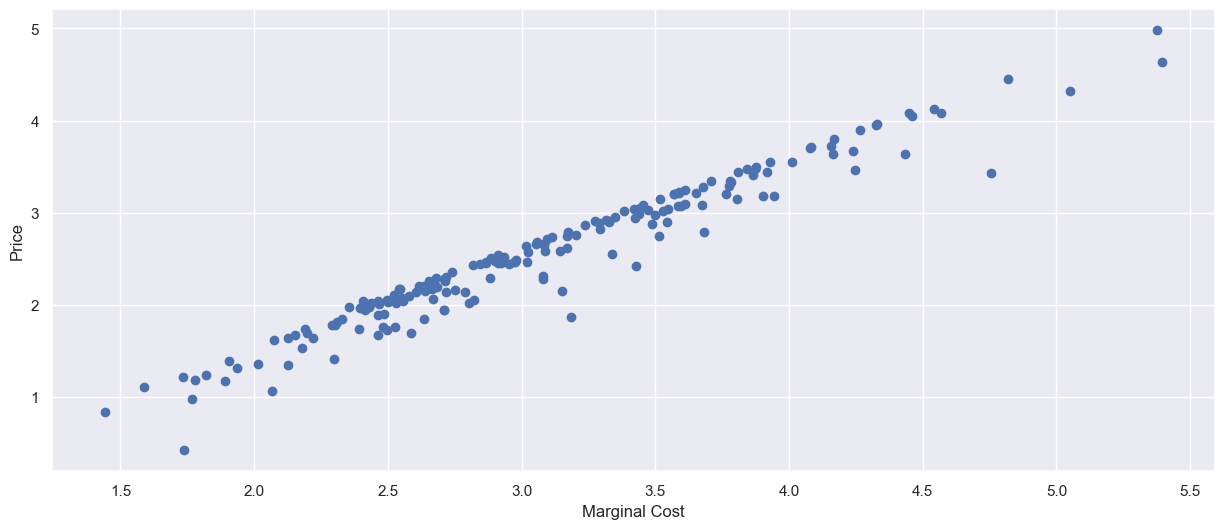

In [150]:
# Scatter plot of price against marginal cost
plt.scatter(df2['price'], df2['mc'])
plt.gca().set(ylabel='Price', xlabel='Marginal Cost')
plt.savefig("price_mc.png")
plt.show()

# Scatter plot price againse zi(theta_hat)

In [151]:
df2

,,,price,share,xvar,wvar,log_share,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,blp1,blp2,blp3,blp4,mc,mc2,upp,p2
prodid,firmid,mktid,,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,5.610647,0,17,18,6,7,0.000000,11.416658,2.132906,2.632906,0.5,2.632906
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,20.700417,0,15,18,5,7,1.952670,8.910361,3.330649,3.830649,0.5,3.830649
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,3.129697,0,16,18,5,7,2.755761,8.910361,2.045528,2.545528,0.5,2.545528
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,2.697010,0,15,18,6,7,0.000000,11.758187,1.965669,2.465669,0.5,2.465669
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,7.487307,0,15,18,4,7,2.529646,8.771171,2.187259,2.687259,0.5,2.687259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1,20,2.708315,0.515946,2.181564,-0.065767,-0.661754,2.738265,0.000000,0,0,0,3,6,4.034082,6.930525,1.944970,2.444970,0.5,2.444970
3,1,20,5.394167,0.000116,2.316431,0.043551,-9.066113,2.483354,0.000000,0,0,0,3,6,3.899215,6.930525,4.630821,5.130821,0.5,5.130821
6,2,20,3.677919,0.012641,1.952670,-0.428108,-4.370777,3.963566,0.000000,0,0,0,3,6,4.977855,6.215646,3.281993,3.781993,0.5,3.781993


### Tax Incidence and HHI-Avg Price Inc

In [152]:
df2['ti']=df2['p2']-df2['price']
avgPriceInc = np.array(df2.reset_index().groupby('mktid').sum()['ti'])
avgPriceInc

array([ 0.20323299,  0.1594374 , -0.18198685,  0.29068308,  0.0113163 ,
       -0.03928594,  0.07109031,  0.32806373,  0.19372316, -1.00432897,
       -0.78263048, -0.96046038,  0.30035497, -0.30403407, -1.53973523,
       -0.01957346, -0.18685879, -0.86951033, -0.29077734, -0.47781413])

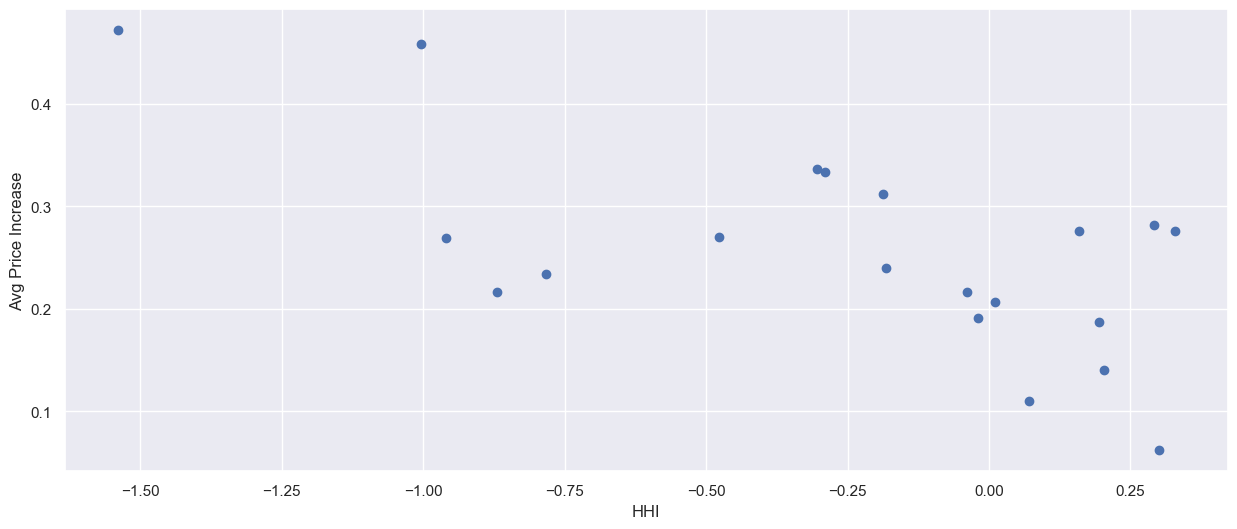

In [153]:
def calculateHHI(df):
    df2 = df.reset_index()
    M = df2.mktid.unique()
    HHI = []
    for mi,m in enumerate(M):
        s = np.array(df2[df2.mktid==m]['share'])
        HHI.append(np.sum(s**2))
    return HHI

HHI = np.array(calculateHHI(df))

plt.scatter(avgPriceInc, HHI)
plt.gca().set(ylabel='Avg Price Increase', xlabel='HHI')
plt.savefig("hhi.png")
plt.show()

### Marginal Cost Determinants

In [154]:
mc_ols = sm.ols(formula="mc ~ wvar", data=df2).fit()
print(mc_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                     mc   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     53.84
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           7.19e-12
Time:                        14:48:51   Log-Likelihood:                -191.95
No. Observations:                 182   AIC:                             387.9
Df Residuals:                     180   BIC:                             394.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5551      0.052     49.336      0.0

eval_env: 1


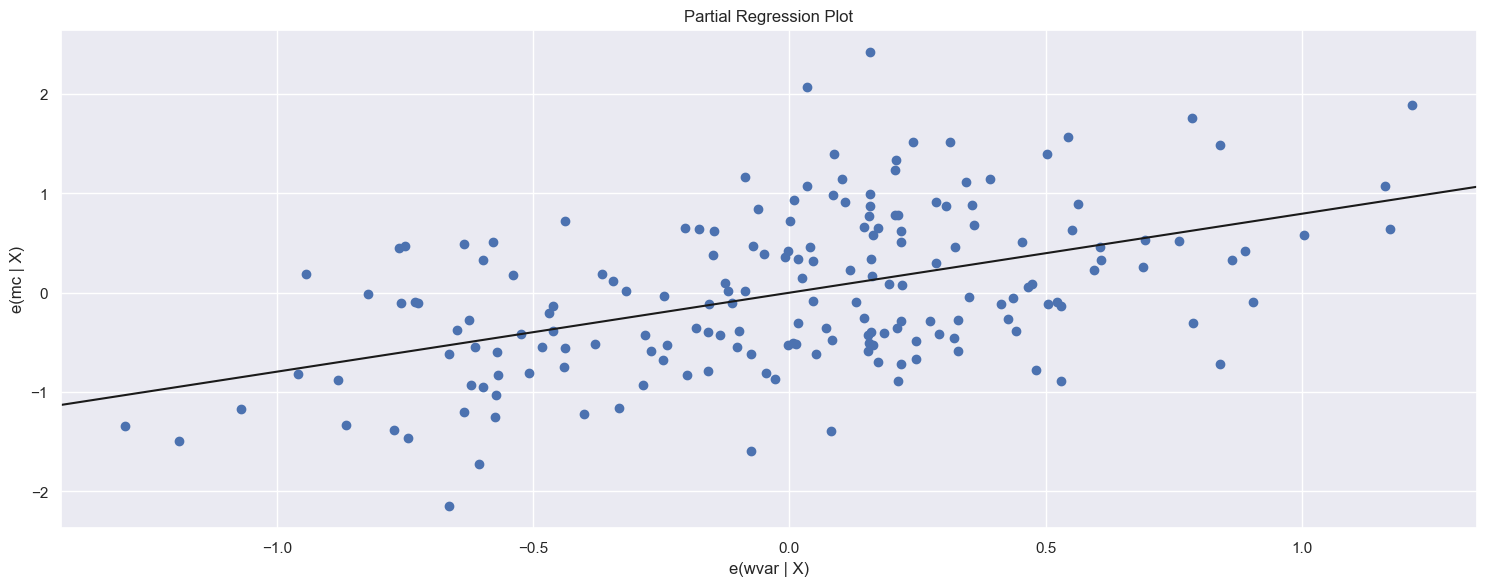

In [155]:
# Partial Regression Plot of logshare-E[logshare|xvar] on price-E[price|xvar]
import statsmodels.api as sm_
fig = sm_.graphics.plot_partregress("mc", "wvar", [], data=df2, obs_labels = False)
fig.tight_layout(pad=1.0)
plt.savefig("partialreg.png")